# Wine Prediction

## Import Libraries & Load Dataset

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
import yaml

# path config
path_config = '..\Config\config.yaml'

# safeload config
config = yaml.safe_load(open(path_config))

filename = config['data_source']['directory'] + config['data_source']['filename']

# load dataset
wine = pd.read_csv(filename, header=None)

df = wine.copy()

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Initial Imformation About Dataset

### Basic Information

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


- Dataset consists of 1599 rows and 12 columns. Data type of all variable are float.

In [20]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


- We can see the average of each column of the dataset. 

### Checking for Null or Missing values

In [21]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

- It looks like there are no missing value. It means dataset can be processed.

# Data Visualzation

- Distribution variable target quality

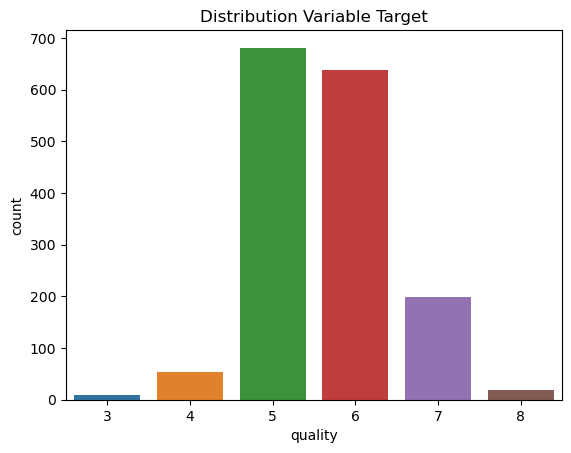

In [22]:
sns.countplot(data=df, x= ['data_source']['target_name'])
plt.title('Distribution Variable Target')
plt.show()

- Visualize the correlation contents in red wine

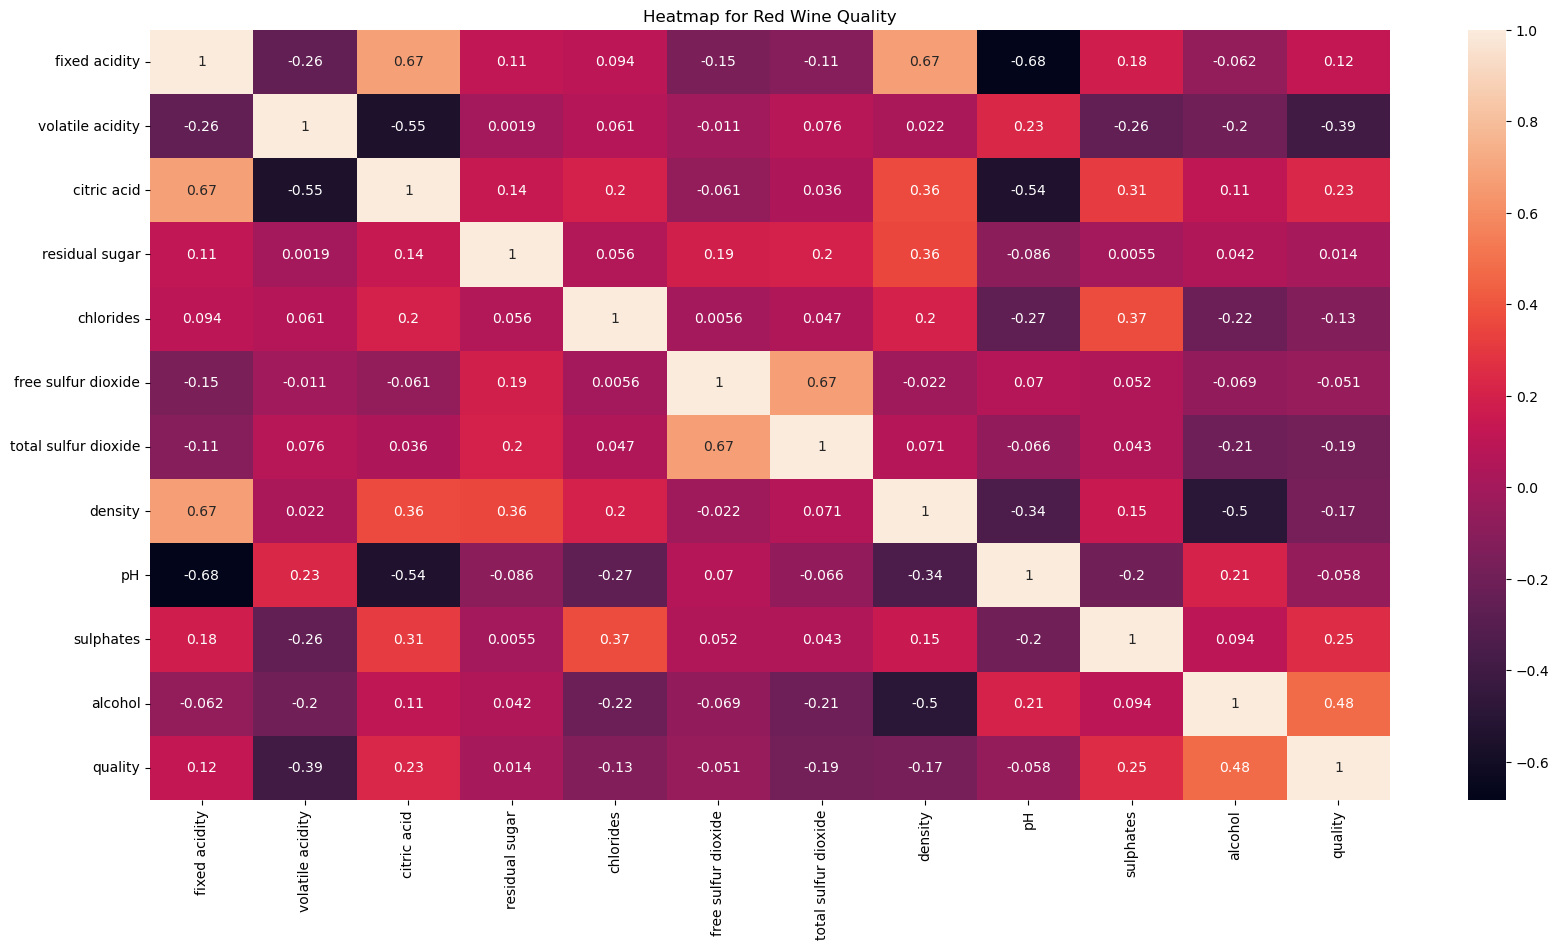

In [23]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)
plt.title("Heatmap for Red Wine Quality")
plt.show()

## Exploratory Data Analysis

- Feature Scaling

1. Scale the dataset by quality

- After reading the Red Wine Quality dataset description we find,
    - quality >= 7 is "good"
    - quality <= 7 is "bad"

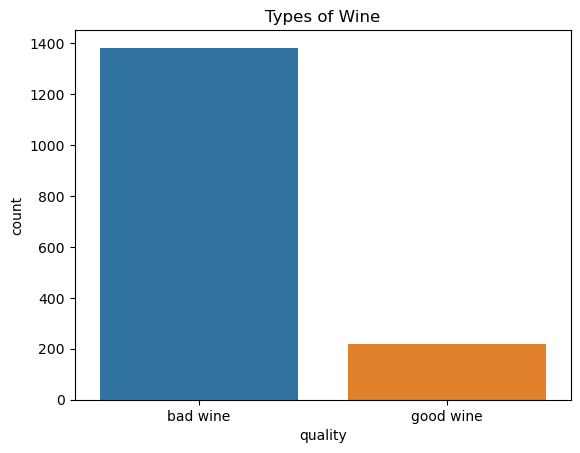

In [24]:
df['data_source']['drop_columns'] = df['data_source']['drop_columns'].apply(lambda x: 1 if x >= 7 else 0)

sns.countplot(data = df, x = ['data_source']['target_name'])
plt.xticks([0,1], ['bad wine','good wine'])
plt.title("Types of Wine")
plt.show()


- from the above visualization we can see that the Dataset is skewed or unbalanced.

2. Resampling Dataset

- for skewed or unbalanced dataset, we can do over sampling using random over sampler for data balancing

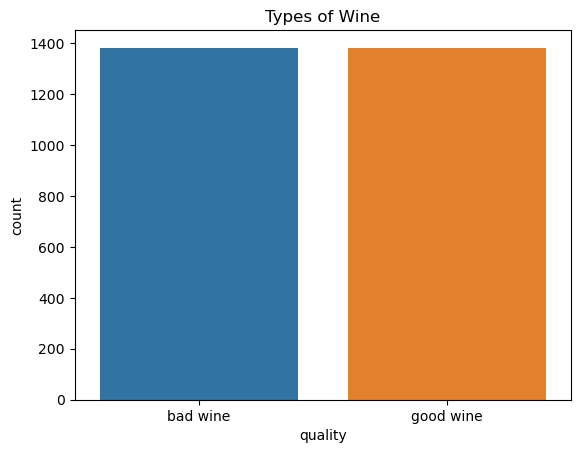

In [25]:
# Sampling Dataset
X = df.drop(['data_source']['drop_columns'], axis=1)
y = df.quality

ran = RandomOverSampler(random_state=['data_source']['random_state'])
X_ros, y_ros = ran.fit_resample(X, y)

sns.countplot(x=y_ros)
plt.xticks([0,1], ['bad wine','good wine'])
plt.title("Types of Wine")
plt.show()

3. Preprocessing Dataset

- Split dataset into train and test

In [26]:
# split dataset to train and test variable 
# use test size of 20% of the data proportion
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=['data_source']['test_size'], random_state=['data_source']['random_state'])
X_train.shape, X_test.shape

((2211, 11), (553, 11))

- Scale dataset with StandardScaler

In [27]:
# scale with StandardScaler
scaler = StandardScaler()

# fit to data training
scaler.fit(X_train)

# transform
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

## Training Models

### Logistic Regression

In [28]:
# Logistic Regression initialization
logreg = LogisticRegression(class_weight=['data_source']['class_weights'], random_state=['data_source']['random_state'])

# Cross Validation
logreg_score = cross_val_score(estimator = ['data_source']['estimator'],
                               X = x_train, y= y_train,
                               scoring = ['data_source']['scoring'],cv = ['data_source']['cv'],
                               verbose = ['data_source']['verbose'], n_jobs=['data_source']['n_jobs'])

# Fit data training
logreg.fit(x_train, y_train)

# Predict data test
y_pred = logreg.predict(x_test)

print('Avarage Recall score', np.mean(logreg_score))
print('Test Recall score', recall_score(y_test, y_pred))

Avarage Recall score 0.8266748566748566
Test Recall score 0.8357664233576643


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


- Based on the similar results obtained from the scores, it can be concluded that the model's performance is good in predicting the target variable.

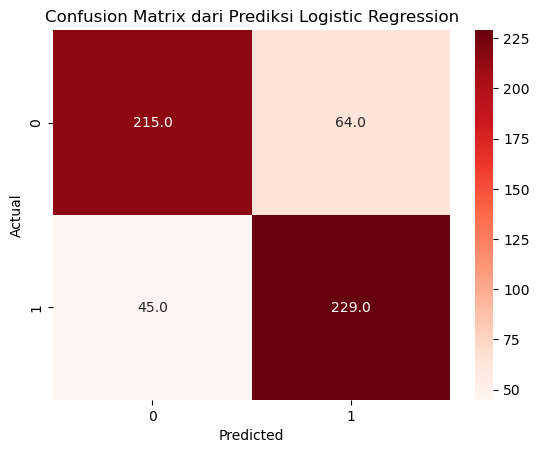

In [29]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Heatmap Confusion Matrix
sns.heatmap(conf_mat, cmap = 'Reds', annot = True, fmt='.1f')
plt.title('Confusion Matrix dari Prediksi Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Model prediction :
- Our model predicted '0' correctly 215 times while predicting '0' incorrectly 64 times
    
- Also it predicted '1' incorrectly 45 times while predicting '1' correctly 229 times

1. Hyperparameter Tuning

In [30]:
# Grid parameters
log_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['data_source']['solver']
    }
# Use RandomizedSearchCV
logreg_cv = RandomizedSearchCV(estimator=['data_source']['estimator'], param_distributions=log_grid,
                                scoring=['data_source']['scoring'], cv=['data_source']['cv'])

# Fit to model
logreg_cv.fit(X_train, y_train)

# Best Score
print(f'Best score: {logreg_cv.best_score_}')
print(f'Best params: {logreg_cv.best_params_}')

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score: 0.833030303030303
Best params: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}


2. Compare Score

In [31]:
# Logistic Regression initialization
logreg_tuned = LogisticRegression(**logreg_cv.best_params_,class_weight=['data_source']['class_weight'], random_state=['data_source']['random_state'])

# Cross Validation
logreg_tuned_score = cross_val_score(estimator = logreg_tuned,
                               X = x_train, y= y_train,
                               scoring = ['data_source']['scoring'],cv = ['data_source']['cv'],
                               verbose = 0)

# Fit data training
logreg_tuned.fit(x_train, y_train)

# Predict data test
y_pred_tuned = logreg_tuned.predict(x_test)

# Cek Score
print('Avarage Recall score', np.mean(logreg_score))
print('Test Recall score', recall_score(y_test, y_pred))
print('Avarage Recall score Tuning', np.mean(logreg_tuned_score))
print('Test Recall score Tuning', recall_score(y_test, y_pred_tuned))


Avarage Recall score 0.8266748566748566
Test Recall score 0.8357664233576643
Avarage Recall score Tuning 0.8293857493857495
Test Recall score Tuning 0.8357664233576643


- From the obtained results, the performance has slightly improved.

### Random Forest

In [32]:
# Random Forest Regression initialization
rfc = RandomForestClassifier(n_estimators=['data_source']['n_estimator'], random_state=['data_source']['random_state'])

# Cross Validation
rf_score = cross_val_score(estimator = ['data_source']['estimator'],
                               X = x_train, y= y_train,
                               scoring = ['data_source']['scoring'],cv = ['data_source']['cv'],
                               verbose = ['data_source']['verbose'], n_jobs=['data_source']['n_jobs'])

# Fit data training
rfc.fit(x_train, y_train)

# Predict data test
y_pred = rfc.predict(x_test)

print('Avarage Recall score', np.mean(rf_score))
print('Test Recall score', recall_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


Avarage Recall score 0.9972972972972972
Test Recall score 1.0


- Based on the similar results obtained from the scores, it can be concluded that the model's performance is good in predicting the target variable.

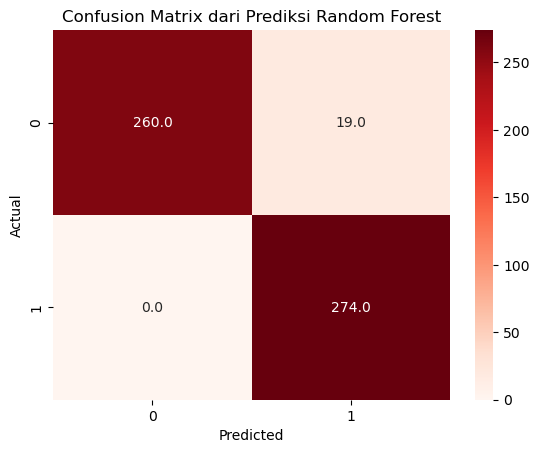

In [33]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Heatmap Confusion Matrix
sns.heatmap(conf_mat, cmap = 'Reds', annot = True, fmt='.1f')
plt.title('Confusion Matrix dari Prediksi Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Model prediction :
- Our model predicted '0' correctly 260 times while predicting '0' incorrectly 19 times
    
- Also it predicted '1' incorrectly 0 times while predicting '1' correctly 274 times

1. Hyperparameter Tuning

In [34]:
# Grid parameters
rf_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 10],
                'min_samples_split': [2, 5, 10]
                }
                
# Use RandomizedSearchCV
rf_cv = RandomizedSearchCV(estimator=['data_source']['estimators'], param_distributions=rf_grid,
                            scoring=['data_source']['scoring'], cv=['data_source']['cv'])

# Fit to model
rf_cv.fit(X_train, y_train)

# Best Score
print(f'Best score: {rf_cv.best_score_}')
print(f'Best params: {rf_cv.best_params_}')

Best score: 0.9981981981981981
Best params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 10}


2. Compare Score

In [35]:
# Random Forest Regression initialization
rf_tuned = RandomForestClassifier(**rf_cv.best_params_, random_state=['data_source']['random_state'])

# Cross Validation
rf_tuned_score = cross_val_score(estimator = rf_tuned,
                               X = x_train, y= y_train,
                               scoring = ['data_source']['scoring'],cv = ['data_source']['cv'],
                               verbose = ['data_source']['verbose'])

# Fit data training
rf_tuned.fit(x_train, y_train)

# Predict data test
y_pred_tuned = rf_tuned.predict(x_test)

# Cek Score
print('Avarage Recall score', np.mean(rf_score))
print('Test Recall score', recall_score(y_test, y_pred))
print('Avarage Recall score Tuning', np.mean(rf_tuned_score))
print('Test Recall score Tuning', recall_score(y_test, y_pred_tuned))

Avarage Recall score 0.9972972972972972
Test Recall score 1.0
Avarage Recall score Tuning 0.9981981981981981
Test Recall score Tuning 1.0


- From the obtained results, the performance has slightly improved.

### Decision Tree

In [41]:
# DecisionTree Regression initialization
dtc = DecisionTreeClassifier(random_state=['data_source']['random_state'])

# Cross Validation
dt_score = cross_val_score(estimator = ['data_source']['estimator'],
                               X = x_train, y= y_train,
                               scoring = ['data_source']['scoring'],cv = ['data_source']['cv'],
                               verbose = ['data_source']['verbose'], n_jobs=['data_source']['n_jobs'])

# Fit data training
dtc.fit(x_train, y_train)

# Predict data test
y_pred = dtc.predict(x_test)

print('Avarage Recall score', np.mean(dt_score))
print('Test Recall score', recall_score(y_test, y_pred))

Avarage Recall score 0.9954791154791154
Test Recall score 1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


- Based on the similar results obtained from the scores, it can be concluded that the model's performance is good in predicting the target variable.

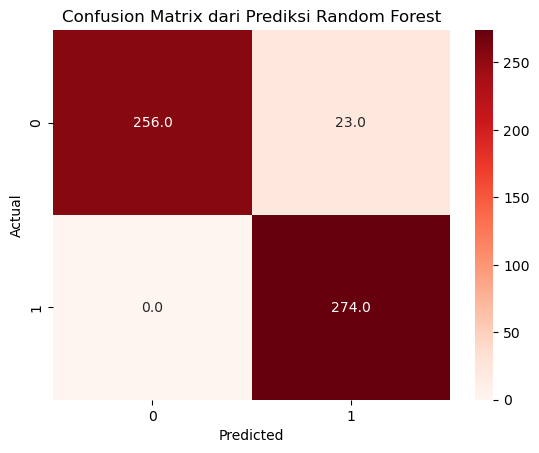

In [37]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Heatmap Confusion Matrix
sns.heatmap(conf_mat, cmap = 'Reds', annot = True, fmt='.1f')
plt.title('Confusion Matrix dari Prediksi Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Model prediction :
- Our model predicted '0' correctly 256 times while predicting '0' incorrectly 23 times
    
- Also it predicted '1' incorrectly 0 times while predicting '1' correctly 274 times

1. Hyperparameter Tuning

In [38]:
# Grid parameters
dt_grid = {
            'max_depth': [3, 5, 10],
            'min_samples_split': [2, 5, 10]
            }
                
# Use RandomizedSearchCV
dt_cv = RandomizedSearchCV(estimator=['data_source']['estimator'], param_distributions=dt_grid,
                            scoring=['data_source']['scoring'], ['data_source']['cv']=10)

# Fit to model
dt_cv.fit(X_train, y_train)

# Best Score
print(f'Best score: {dt_cv.best_score_}')
print(f'Best params: {dt_cv.best_params_}')

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best score: 0.9936936936936938
Best params: {'min_samples_split': 2, 'max_depth': 10}


2. Compare Score

In [39]:
# DecisionTree Regression initialization
dt_tuned = RandomForestClassifier(**dt_cv.best_params_, random_state=['data_source']['random_state'])

# Cross Validation
dt_tuned_score = cross_val_score(estimator = dt_tuned,
                               X = x_train, y= y_train,
                               scoring = ['data_source']['scoring'],cv = ['data_source']['cv'],
                               verbose = ['data_source']['verbose'])

# Fit data training
dt_tuned.fit(x_train, y_train)

# Predict data test
y_pred_tuned = dt_tuned.predict(x_test)

# Cek Score
print('Avarage Recall score', np.mean(dt_score))
print('Test Recall score', recall_score(y_test, y_pred))
print('Avarage Recall score Tuning', np.mean(dt_tuned_score))
print('Test Recall score Tuning', recall_score(y_test, y_pred_tuned))

Avarage Recall score 0.9954791154791154
Test Recall score 1.0
Avarage Recall score Tuning 0.9981981981981981
Test Recall score Tuning 1.0


- From the obtained results, the performance has slightly improved.

## Conclution

## Future Work